In [4]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

def load_and_split_dataset(dataset_path, target_length, target_size=(300, 300), val_size=0.2):

    # Initialize data and labels
    X = []
    y = []

    # Map class names to labels
    class_map = {"Motion": 0, "Static": 1}

    # Iterate over classes
    for class_name, class_label in class_map.items():
        class_folder = os.path.join(dataset_path, class_name)
        if not os.path.exists(class_folder):
            print(f"Class folder '{class_folder}' does not exist. Skipping...")
            continue

        # Iterate over video files in the class folder
        for video_file in os.listdir(class_folder):
            video_path = os.path.join(class_folder, video_file)
            if not video_file.lower().endswith(('.mp4', '.avi', '.mkv', '.mov', '.npy')):
                print(f"Skipping non-video file: {video_file}")
                continue

            # Read video and preprocess
            video_frames = read_video(video_path, target_length, target_size)
            if video_frames is not None:
                X.append(video_frames)
                y.append(class_label)

    # Convert to NumPy arrays
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)

    # Normalize pixel values to [0, 1]
    X = X / 255.0

    print(f"Dataset loaded: {len(X)} samples, shape: {X.shape}")

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=val_size, random_state=42, stratify=y
    )

    print(f"Split dataset: {len(X_train)} train, {len(X_val)} validation")
    return X_train, X_val, y_train, y_val


def read_video(video_path, target_length, target_size):

    frames = []

    # Load video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Could not open video file: {video_path}")
        return None

    # Read each frame
    success, frame = cap.read()
    while success:
        # Resize the frame
        resized_frame = cv2.resize(frame, target_size)
        frames.append(resized_frame)
        success, frame = cap.read()
    cap.release()

    # Ensure the video has the desired number of frames
    if len(frames) < target_length:
        # If too few frames, repeat the last frame
        frames += [frames[-1]] * (target_length - len(frames))
    elif len(frames) > target_length:
        # If too many frames, randomly sample
        start = np.random.randint(0, len(frames) - target_length + 1)
        frames = frames[start:start + target_length]

    return np.array(frames, dtype=np.float32)

In [13]:
# input Conventional camera or Bionic eye here to chose the dataset
foldername="Bionic eye"

dataset_path = foldername+'\\'

target_length = 10 

val_size = 0.2  # 20% for the validation set

# Load and split the dataset
X_train, X_val, y_train, y_val = load_and_split_dataset(
    dataset_path, target_length, val_size=val_size
)


Dataset loaded: 112 samples, shape: (112, 10, 300, 300, 3)
Split dataset: 89 train, 23 validation


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def create_optimized_cnn_lstm_model(num_classes):
    model = Sequential([
        TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=(None, 300, 300, 3)),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Dropout(0.25)),
        
        TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Dropout(0.25)),
        
        TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Dropout(0.25)),
        
        TimeDistributed(Flatten()),
        LSTM(256, return_sequences=False),
        Dropout(0.5),
        
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

num_classes = 2
model = create_optimized_cnn_lstm_model(num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 300, 300, 3  896      
 ibuted)                     2)                                  
                                                                 
 time_distributed_1 (TimeDis  (None, None, 300, 300, 3  128      
 tributed)                   2)                                  
                                                                 
 time_distributed_2 (TimeDis  (None, None, 300, 300, 3  9248     
 tributed)                   2)                                  
                                                                 
 time_distributed_3 (TimeDis  (None, None, 150, 150, 3  0        
 tributed)                   2)                                  
                                                                 
 time_distributed_4 (TimeDis  (None, None, 150, 150, 3  

In [7]:
# Training parameters
batch_size = 8
epochs = 5

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/5
12/12 [==============================] - 95s 8s/step - loss: 0.8032 - accuracy: 0.5169 - val_loss: 0.9002 - val_accuracy: 0.4783
Epoch 2/5
12/12 [==============================] - 105s 9s/step - loss: 0.7390 - accuracy: 0.6404 - val_loss: 1.1351 - val_accuracy: 0.4783
Epoch 3/5
12/12 [==============================] - 102s 9s/step - loss: 0.5233 - accuracy: 0.7753 - val_loss: 1.2406 - val_accuracy: 0.4783
Epoch 4/5
12/12 [==============================] - 100s 8s/step - loss: 0.4613 - accuracy: 0.7865 - val_loss: 1.2062 - val_accuracy: 0.4783
Epoch 5/5
12/12 [==============================] - 95s 8s/step - loss: 0.3544 - accuracy: 0.8876 - val_loss: 1.1239 - val_accuracy: 0.4783


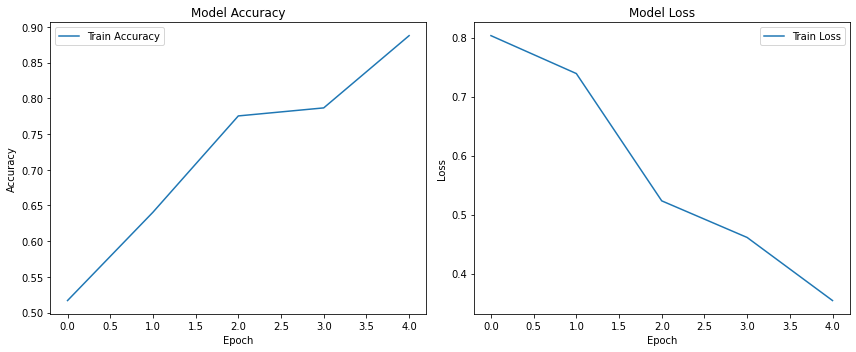

In [9]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()